# Markov Switching AR Process

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tensorflow import keras

## Sequence Generation

In [ ]:
def y_1(y, params):
  a_1_1, a_2_1, a_3_1 = params[0], params[1], params[2]
  y_t = a_1_1 + a_2_1*y[0][0] + a_3_1*y[0][1] + np.random.normal(0, 1)
  return np.hstack([y_t, y[0][0]]).reshape(1,2)

def y_2(y, params):
  a_1_2, a_2_2, a_3_2 = params[0], params[1], params[2]
  y_t = a_1_2 + a_2_2*y[0][0] + a_3_2*y[0][1] + np.random.normal(0, 1)
  return np.hstack([y_t, y[0][0]]).reshape(1, 2)

In [ ]:
def gen_series(T, seed, y_0=[1,2]):
  np.random.seed(seed)
  params_1 = [-0.2, 1.2, -0.3]
  params_2 = [0.2, 0.4, -0.3]
  y_0 = np.array([[y_0[0], y_0[1]]])
  y = y_0
  series = [y_0[0][1], y_0[0][0]]
  state = np.random.randint(1,3)

  for period in range(T+100-2):
    if state == 1:
      y = y_1(y, params_1)
      series.append(y[0][0])
      if np.random.uniform(0,1) > 0.83:
        state = 2
        continue

    if state == 2:
      y = y_2(y, params_2)
      series.append(y[0][0])
      if np.random.uniform(0,1) > 0.25:
        state = 1
        continue

  return np.array(series[100:]).reshape(len(series)-100, 1)

In [ ]:
x = gen_series(50, 1)
len(x), x.shape

(50, (50, 1))

## Regression Model

In [ ]:
# Load data
data = np.array(series[100:])

# Create a dictionary of regimes and transition probabilities
regimes = {
    'low': {
        'transition': 0.17,
        'params': [-0.2, 1.2, -0.3]
    },
    'high': {
        'transition': 0.75,
        'params': [0.2, 0.4, -0.3]
    }
}

# Add a column of 1s to the exogenous variables for each regime
for regime in regimes.values():
    regime['params'].append(1)

# Create the model and fit it to the data
model = sm.tsa.MarkovAutoregression(data, k_regimes=len(regimes), order=2, switching_ar=True)
res = model.fit()

# Print summary of the model
print(res.summary())

NameError: ignored

# Genetic Algorithm

## Imports

In [ ]:
import numpy as np
import statsmodels.tsa
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from math import sqrt
plt.rcParams["figure.dpi"] = 125
plt.style.use("default")

def NRMSE(Y_true, Y_pred):
    numerator = np.sqrt(np.mean((Y_true - Y_pred)**2))
    denominator = np.abs(np.mean(Y_true))
    return numerator / denominator

from keras.models import Sequential
from math import sqrt
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import pearsonr
from threading import Thread
from queue import Queue
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

models = [{'index': 0,
  'bs': 1,
  'hs': 1,
  'win_len': 2,
  'epochs': 13,
  'num_nodes': np.array([2])},
 {'index': 1,
  'bs': 2,
  'hs': 1,
  'win_len': 3,
  'epochs': 13,
  'num_nodes': np.array([13])},
 {'index': 2,
  'bs': 2,
  'hs': 1,
  'win_len': 3,
  'epochs': 12,
  'num_nodes': np.array([19])},
 {'index': 3,
  'bs': 1,
  'hs': 2,
  'win_len': 2,
  'epochs': 13,
  'num_nodes': np.array([24,  1])},
 {'index': 4,
  'bs': 1,
  'hs': 1,
  'win_len': 3,
  'epochs': 19,
  'num_nodes': np.array([3])},
 {'index': 5,
  'bs': 1,
  'hs': 2,
  'win_len': 2,
  'epochs': 13,
  'num_nodes': np.array([ 8, 22])},
 {'index': 6,
  'bs': 2,
  'hs': 2,
  'win_len': 2,
  'epochs': 11,
  'num_nodes': np.array([ 5, 15])},
 {'index': 7,
  'bs': 1,
  'hs': 1,
  'win_len': 3,
  'epochs': 13,
  'num_nodes': np.array([14])},
 {'index': 8,
  'bs': 1,
  'hs': 2,
  'win_len': 3,
  'epochs': 18,
  'num_nodes': np.array([14, 12])},
 {'index': 9,
  'bs': 1,
  'hs': 1,
  'win_len': 3,
  'epochs': 10,
  'num_nodes': np.array([10])}]

# Building the Algorithm

## 1. Initialise Population

Here we are creating a randomly generated set of 10 models, each with different hyperparmaeters, which constitute generation 0.

In [ ]:
pop_size = 10
limit_dict = {"bs": (1, 64), "hs": (1, 7), "win_len": (1, 7), "epochs": (50, 150), "num_nodes": (1, 256)}
limit_dict = {"bs": (1, 2), "hs": (1, 2), "win_len": (1, 3), "epochs": (10, 20), "num_nodes": (1, 25)}
batch_size = np.random.randint(limit_dict["bs"][0], limit_dict["bs"][1]+1, pop_size)
hidden_size = np.random.randint(limit_dict["hs"][0], limit_dict["hs"][1]+1, pop_size)
win_length = np.random.randint(limit_dict["win_len"][0], limit_dict["win_len"][1]+1, pop_size)
epochs = np.random.randint(limit_dict["epochs"][0], limit_dict["epochs"][1]+1, pop_size)
num_nodes = [np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, hidden_size[i]) for i in range(pop_size)]

models = [{"index": i, "bs": batch_size[i], "hs": hidden_size[i], "win_len": win_length[i], "epochs": epochs[i], "num_nodes": num_nodes[i]} for i in range(pop_size)]

In [ ]:
limit_dict = {"bs": (1, 2), "hs": (1, 2), "win_len": (1, 3), "epochs": (10, 20), "num_nodes": (1, 25)}

## 2. Evaluate Fitness

- In this code, we choose to create n_series number of generated series, randomised through choosing random seeds.
- The length of each series, T, is also determined randomly from a choice of 3 sizes.
- We then loop over each series and train all 10 model specifications to each, collecting the error data for each.

In [ ]:
# Evaluate fitness.
n_series = 1
n_features = 1
test_size = 0.1
seeds = np.random.randint(1, 1001, n_series)
T = np.random.choice([100, 250, 500], n_series)
T = np.random.choice([400], n_series)
series_data = [gen_series(T[i], seeds[i]) for i in range(n_series)]
error_df = pd.DataFrame(columns=["model_i", "Seed", "T", "win_len", "bs", "hs", "epochs", "num_nodes", "NRMSE", "RMSE", "corr"])

for index, series in enumerate(series_data):
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(series)
  #train_data, test_data = scaled_data[:-int(len(scaled_data)*test_size)], scaled_data[-int(len(scaled_data)*test_size):]

  for model_i, model in enumerate(models):
    test_size_2 = (test_size*len(series) + model["win_len"])/len(series)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, scaled_data,
                                                                    test_size=test_size_2, shuffle=False)

    train_gen = TimeseriesGenerator(x_train, y_train, length=model["win_len"], sampling_rate=1, batch_size=model["bs"])
    test_gen = TimeseriesGenerator(x_test, y_test, length=model["win_len"], sampling_rate=1, batch_size=model["bs"])

    model_lstm = Sequential()
    model_lstm.add(LSTM(model["num_nodes"][0], activation="relu", input_shape=(model["win_len"], n_features), return_sequences=True))

    for i in range(1, model["hs"]-1):
        model_lstm.add(LSTM(model["num_nodes"][i], activation="relu", return_sequences=True))

    model_lstm.add(LSTM(model["num_nodes"][-1], activation="relu", return_sequences=False))
    model_lstm.add(Dense(1))

    model_lstm.compile(optimizer="adam", loss="mse")
    model_lstm.fit(train_gen, epochs=model["epochs"], shuffle=False, verbose=True)

    Y_hat = model_lstm.predict(test_gen)
    Y_hat_NRMSE = NRMSE(y_test[model["win_len"]:], Y_hat)
    Y_hat_RMSE = sqrt(mean_squared_error(y_test[model["win_len"]:], Y_hat))
    Y_hat_corr = pearsonr(y_test[model["win_len"]:].reshape(len(Y_hat)), Y_hat.reshape(len(Y_hat)))
    error_df_row =  pd.DataFrame({"model_i": model_i, "Seed": seeds[index], "T": T[index], "win_len": model["win_len"], "bs": model["bs"], "hs": model["hs"], "epochs": model["epochs"], "num_nodes": str(model["num_nodes"]), "NRMSE": Y_hat_NRMSE, "RMSE": Y_hat_RMSE, "corr": (Y_hat_corr.statistic, Y_hat_corr.pvalue)})
    error_df = pd.concat([error_df, error_df_row], axis=0)

In [ ]:
error_df = pd.read_pickle("test_error_df_2.pkl")
error_df_grouped = error_df.groupby("model_i").mean().copy()["NRMSE"]

## 3. Selection

- Here we create a selection dataframe which is a copy of the mean NRMSEs for each model.
- This NRMSE is then used to define a probability distribution from which we sample in a bootstrapped manner.
- This creates the child_models array, with all the newly selected models which are typically better performers.
- This section outputs the selected parent models.

In [ ]:
selection_df = pd.DataFrame(error_df.groupby("model_i")["NRMSE"].mean().copy())

def random_draw(df, n_draws, target="NRMSE"):
  res = pd.DataFrame(columns=["Draw"])
  df = df.copy()
  df["p_selection"] = df[target]/df[target].sum()
  df["p_cum"] = df["p_selection"].cumsum()
  for i in range(n_draws):
      res = pd.concat([res, pd.DataFrame({"Draw": df.loc[df["p_cum"] > np.random.uniform()].iloc[0].name}, index=[i])], axis=0)
  return res

#FAKE_test_df = pd.DataFrame({"NRMSE": [0.1, 0.2, 0.2, 0.3, 0.2, 0.3, 0.1, 0.5, 0.5, 1]})
model_selections = random_draw(selection_df, n_draws=10).to_numpy()

selected_parents = []
for i in model_selections:
  for model in models:
    if model["index"] == i:
      selected_parents.append(model)

## 4. Reproduction and Cross-Over

In [ ]:
def find_homog_models(parents):
  temp = [len(models["num_nodes"]) for model in parents]
  target_hs = temp[np.argmax([temp.count(num_nodes) for num_nodes in temp])]
  homog_models = [model for model in parents if model["hs"] == target_hs]

  return homog_models

def find_homog_models(parent, selected_parents):
  hs = parent["hs"]
  homog_models = [parent for parent in selected_parents if parent["hs"] == hs]

  return homog_models

In [ ]:
# Reproduction
## iterate over selected parents, randomising between mutating, cross-over, and nothing.
lineage = []
for parent in selected_parents:
  choice = np.random.randint(0,2)

  # Mutation
  if choice == 0:
    n_continuous = np.random.lognormal(mean=0, sigma=0.8)
    n_genes = np.round(n_continuous).astype(int)
    if n_genes > len(limit_dict): n_genes = len(limit_dict) - 2
    if n_genes == 0: continue
    mutant_genes = np.random.choice(list(parent.keys())[1:], size=n_genes, replace=False)

    #print("MUTATION\nParent (before):", parent)
    #print("Genes:", mutant_genes)
    if "num_nodes" in mutant_genes and "hs" not in mutant_genes:
      print("M (before): 'hs & nn", parent["num_nodes"])
      parent["num_nodes"] = np.array(np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, size=parent["hs"]))
      mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
      print("M (after): 'hs & nn", parent["num_nodes"])
      if np.NaN in parent["num_nodes"]: raise StopIteration


    if "num_nodes" in mutant_genes and "hs" in mutant_genes:
      parent["hs"] = np.random.randint(limit_dict["hs"][0], limit_dict["hs"][1]+1)
      print("M (before): hs & nn", parent["num_nodes"])
      parent["num_nodes"] = np.array(np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, size=parent["hs"]))
      print("M (after): hs & nn", parent["num_nodes"])
      if np.NaN in parent["num_nodes"]: raise StopIteration
      mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
      mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")

    if "hs" in mutant_genes and "num_nodes" not in mutant_genes:
      parent["hs"] = np.random.randint(limit_dict["hs"][0], limit_dict["hs"][1]+1)
      print("M (before): hs & nn'", parent["num_nodes"])
      parent["num_nodes"] = np.array(np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, size=parent["hs"]))
      print("M (after): hs & nn'", parent["num_nodes"])
      if np.NaN in parent["num_nodes"]: raise StopIteration

      mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")

    for key in mutant_genes:
      parent[key] = np.random.randint(limit_dict[key][0], limit_dict[key][1]+1)
    #print("Parent (after):", parent)

  # Cross-Over
  if choice == 1:
    print("CROSSOVER")
    n_parents_cont = np.random.lognormal(mean=0, sigma=0.8)
    n_parents = np.round(n_parents_cont).astype(int)
    if n_parents > len(selected_parents): n_parents = len(selected_parents)
    if n_parents == 0: continue

    n_genes_cont = np.random.lognormal(mean=0.5, sigma=0.8)
    n_genes = np.round(n_genes_cont).astype(int)
    if n_genes > len(limit_dict)-2: n_genes = len(limit_dict)-2
    if n_genes == 0: continue

    print("Chosen Parents:", n_parents, "\nNumber of genes:", n_genes)
    mutant_genes = np.random.choice(list(parent.keys())[1:], size=n_genes, replace=False)
    print("Mutant genes:", mutant_genes)

    # Need to change the dataframe to pull from if the num_nodes is present.
    if "num_nodes" in mutant_genes and "hs" not in mutant_genes:
      potential_parents = find_homog_models(parent, models)
      indices = [parent["index"] for parent in potential_parents]
      if n_parents > len(potential_parents): n_parents = len(potential_parents)
      temp = pd.DataFrame()
      for index in indices:
        temp = pd.concat([selection_df.loc[selection_df.index == index], temp], axis=0)
      # Retrieve model indexes from random draw of homogenised parents.
      breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]


      # Take the mean of the number of nodes across the parents.
      mean_nodes = []
      for i in range(parent["hs"]):
        temp = []
        for n in range(len(breeding_parents)):
          temp.append(breeding_parents[n]["num_nodes"][i])
        mean_nodes.append(np.mean(temp))

      print("Cross (before): nn & hs'", parent["num_nodes"])
      parent["num_nodes"] = np.array(mean_nodes)
      print("Cross (after): nn & hs'", parent["num_nodes"])
      if np.nan in parent["num_nodes"]: raise StopIteration
      mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")

    ## SHOULD WE BE ONLY BE MERGING FROM THE POOL OFP SELECTED??

    if "num_nodes" in mutant_genes and "hs" in mutant_genes:
      # Randomly assign a new hs based upon the whole sample of models.
      breeding_parents = [parent for i in random_draw(selection_df, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]
      parent["hs"] = int(np.mean([parent["hs"] for parent in breeding_parents]))

      # Find parents with equal hs to new value.
      potential_parents = find_homog_models(parent, models)
      indices = [parent["index"] for parent in potential_parents]
      if n_parents > len(potential_parents): n_parents = len(potential_parents)
      temp = pd.DataFrame()
      for index in indices:
        temp = pd.concat([selection_df.loc[selection_df.index == index], temp], axis=0)
      # Retrieve model indexes from random draw of homogenised parents.
      breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]

      # Take the mean of the number of nodes across the parents.
      mean_nodes = []
      for i in range(parent["hs"]):
        temp2 = []
        for n in range(len(breeding_parents)):
          temp2.append(breeding_parents[n]["num_nodes"][i])
        mean_nodes.append(np.mean(temp2))

      print("Cross (before): nn & hs", parent["num_nodes"])
      parent["num_nodes"] = np.array(mean_nodes)
      print("Cross (after): nn & hs", parent["num_nodes"])
      if np.nan in parent["num_nodes"]: raise StopIteration
      mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
      mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")


    if "hs" in mutant_genes and "num_nodes" not in mutant_genes:
      ## CHANGE hs
      # Here we are just changing the hidden size, then changing the number of nodes to match the new size.
      indices = [parent["index"] for parent in models]
      if n_parents > len(indices): n_parents = len(indices)
      temp = pd.DataFrame()
      for index in indices:
        temp = pd.concat([pd.DataFrame(error_df_grouped.loc[error_df_grouped.index == index]), temp], axis=0)
      # Retrieve model indexes from random draw of homogenised parents.
      breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]
      parent["hs"] = int(np.mean([parent["hs"] for parent in breeding_parents]))

      ## RECONFIG num_nodes
      # Once you have selected a new hs, you need to reconfigure the number of nodes for the model.
      potential_parents = find_homog_models(parent, models)
      if len(potential_parents) == 0: continue

      indices = [parent["index"] for parent in potential_parents]
      if n_parents > len(potential_parents): n_parents = len(potential_parents)
      temp = pd.DataFrame()
      for index in indices:
        temp = pd.concat([selection_df.loc[selection_df.index == index], temp], axis=0)
      # Retrieve model indexes from random draw of homogenised parents.
      breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]

      # Take the mean of the number of nodes across the parents.
      mean_nodes = []
      for i in range(parent["hs"]):
        temp = []
        for n in range(len(breeding_parents)):
          temp.append(breeding_parents[n]["num_nodes"][i])
        mean_nodes.append(np.mean(temp))

      print("Cross (before): 'nn & hs", parent["num_nodes"])
      parent["num_nodes"] = np.array(mean_nodes)
      print("Cross (after): 'nn & hs", parent["num_nodes"])
      if np.nan in parent["num_nodes"]: raise StopIteration

      mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
      mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")


    breeding_parents = [models[i[0]] for i in random_draw(selection_df, n_draws=n_parents).to_numpy()]
    for gene in mutant_genes:
      #print("Mutant gene:", key)
      parent_gene_values = [parent[gene] for parent in breeding_parents]
      parent_gene_mean = np.round(np.mean(parent_gene_values))
      parent[gene] = parent_gene_mean

# Genetic Algorithm

### Functions

In [ ]:
def init(pop_size=10):
  limit_dict = {"bs": (1, 64), "hs": (2, 7), "win_len": (1, 6), "epochs": (50, 125), "num_nodes": (1, 256)}
  #limit_dict = {"bs": (1, 2), "hs": (1, 2), "win_len": (1, 3), "epochs": (10, 20), "num_nodes": (1, 10)}
  batch_size = np.random.randint(limit_dict["bs"][0], limit_dict["bs"][1]+1, pop_size)
  hidden_size = np.random.randint(limit_dict["hs"][0], limit_dict["hs"][1]+1, pop_size)
  win_length = np.random.randint(limit_dict["win_len"][0], limit_dict["win_len"][1]+1, pop_size)
  epochs = np.random.randint(limit_dict["epochs"][0], limit_dict["epochs"][1]+1, pop_size)
  num_nodes = [np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, hidden_size[i]) for i in range(pop_size)]

  models = [{"index": i, "bs": batch_size[i], "hs": hidden_size[i], "win_len": win_length[i], "epochs": epochs[i], "num_nodes": num_nodes[i]} for i in range(pop_size)]
  return models, limit_dict

def print_dict(target):
  for item in target:
    print(item)

def eval_fitness(target_models):
  print("EVAL_FITNESS: inputted target_models: \n")
  for item in target_models:
    print(item)
  # Evaluate fitness.
  n_series = 1
  n_features = 1
  test_size = 0.1
  seeds = np.random.randint(1, 1001, n_series)
  T = np.random.choice([100, 250, 500], n_series)
  series_data = [gen_series(T[i], seeds[i]) for i in range(n_series)]
  error_df = pd.DataFrame(columns=["model_i", "Seed", "T", "win_len", "bs", "hs", "epochs", "num_nodes", "NRMSE", "RMSE", "corr"])

  for index, series in enumerate(series_data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(series)
    #train_data, test_data = scaled_data[:-int(len(scaled_data)*test_size)], scaled_data[-int(len(scaled_data)*test_size):]

    for model_i, model in enumerate(target_models):
      test_size_2 = (test_size*len(series) + model["win_len"])/len(series)
      x_train, x_test, y_train, y_test = train_test_split(scaled_data, scaled_data,
                                                                      test_size=test_size_2, shuffle=False)

      train_gen = TimeseriesGenerator(x_train, y_train, length=model["win_len"], sampling_rate=1, batch_size=model["bs"])
      test_gen = TimeseriesGenerator(x_test, y_test, length=model["win_len"], sampling_rate=1, batch_size=model["bs"])

      model_lstm = Sequential()
      model_lstm.add(LSTM(model["num_nodes"][0], activation="relu", input_shape=(model["win_len"], n_features), return_sequences=True))

      for i in range(1, model["hs"]-1):
          model_lstm.add(LSTM(model["num_nodes"][i], activation="relu", return_sequences=True))

      model_lstm.add(LSTM(model["num_nodes"][-1], activation="relu", return_sequences=False))
      model_lstm.add(Dense(1))

      model_lstm.compile(optimizer="adam", loss="mse")
      model_lstm.fit(train_gen, epochs=model["epochs"], shuffle=False, verbose=False)

      Y_hat = model_lstm.predict(test_gen)
      Y_hat_NRMSE = NRMSE(y_test[model["win_len"]:], Y_hat)
      Y_hat_RMSE = sqrt(mean_squared_error(y_test[model["win_len"]:], Y_hat))
      Y_hat_corr = pearsonr(y_test[model["win_len"]:].reshape(len(Y_hat)), Y_hat.reshape(len(Y_hat)))[0]
      error_df_row =  pd.DataFrame({"model_i": target_models[model_i]["index"], "Seed": seeds[index], "T": T[index], "win_len": model["win_len"], "bs": model["bs"], "hs": model["hs"], "epochs": model["epochs"], "num_nodes": str(model["num_nodes"]), "NRMSE": Y_hat_NRMSE, "RMSE": Y_hat_RMSE, "corr": Y_hat_corr}, index=[target_models[model_i]["index"]])
      error_df = pd.concat([error_df, error_df_row], axis=0)
  print("EVAL_FITNESS: Returned error_df \n", error_df)
  return error_df


def random_draw(df, n_draws, target="NRMSE"):
  res = pd.DataFrame(columns=["Draw"])
  df = df.copy()
  df["p_selection"] = df[target]/df[target].sum()
  df["p_cum"] = df["p_selection"].cumsum()
  for i in range(n_draws):
      res = pd.concat([res, pd.DataFrame({"Draw": df.loc[df["p_cum"] > np.random.uniform()].iloc[0].name}, index=[i])], axis=0)
  return res

def selection(selection_df, models, n=10):
  indices = [model["index"] for model in models]
  temp = pd.DataFrame()
  for index in indices:
      temp = pd.concat([selection_df.loc[selection_df.index == index], temp], axis=0)
  model_selections = random_draw(temp, n_draws=n).to_numpy()

  selected_parents = []
  for index in model_selections:
    for model in models:
      if model["index"] == index:
        selected_parents.append(model.copy())
        break

  return selected_parents


def find_homog_models(parent, selected_parents):
  hs = parent["hs"]
  index = parent["index"]
  homog_models = [parent for parent in selected_parents if parent["hs"] == hs and parent["index"] != index]

  return homog_models

def reproduction(selected_parents, models, error_df, limit_dict):
  print("REPRODUCTION (input): \n selected_parents: \n", selected_parents, "\n models \n,", models, "\nerror_df:\n", error_df)
  ## iterate over selected parents, randomising between mutating, cross-over, and nothing.
  for parent in selected_parents:
    print("Parent (before)", parent)
    choice = np.random.randint(0,2)

    #### ––––––––––––––––––––––––– Mutation ––––––––––––––––––––––––– ####
    if choice == 0:
      n_continuous = np.random.lognormal(mean=0.5, sigma=0.8)
      n_genes = np.round(n_continuous).astype(int)
      if n_genes > len(limit_dict): n_genes = len(limit_dict) - 2
      if n_genes == 0: continue
      mutant_genes = np.random.choice(list(parent.keys())[1:], size=n_genes, replace=False)

      print("MUTATION\nParent (before):", parent)
      print("Genes:", mutant_genes)
      if "num_nodes" in mutant_genes and "hs" not in mutant_genes:
        print("M (before): 'hs & nn", parent["num_nodes"])
        parent["num_nodes"] = np.array(np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, size=parent["hs"]))
        mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
        print("M (after): 'hs & nn", parent["num_nodes"])

      if "num_nodes" in mutant_genes and "hs" in mutant_genes:
        parent["hs"] = np.random.randint(limit_dict["hs"][0], limit_dict["hs"][1]+1)
        print("M (before): hs & nn", parent["num_nodes"])
        parent["num_nodes"] = np.array(np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, size=parent["hs"]))
        print("M (after): hs & nn", parent["num_nodes"])
        mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
        mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")

      if "hs" in mutant_genes and "num_nodes" not in mutant_genes:
        parent["hs"] = np.random.randint(limit_dict["hs"][0], limit_dict["hs"][1]+1)
        print("M (before): hs & nn'", parent["num_nodes"])
        parent["num_nodes"] = np.array(np.random.randint(limit_dict["num_nodes"][0], limit_dict["num_nodes"][1]+1, size=parent["hs"]))
        print("M (after): hs & nn'", parent["num_nodes"])
        mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")

      for key in mutant_genes:
        mutated_gene = np.random.randint(limit_dict[key][0], limit_dict[key][1]+1)
        while mutated_gene == parent[key]:
          mutated_gene = np.random.randint(limit_dict[key][0], limit_dict[key][1]+1)
        parent[key] = mutated_gene
      parent["index"] = parent["index"] + 10
      print("Parent (after):", parent)

    #### ––––––––––––––––––––––––– Cross-Over ––––––––––––––––––––––––– ####
    if choice == 1:
      print("CROSSOVER")
      print(parent)
      n_parents_cont = np.random.lognormal(mean=0, sigma=0.8)
      n_parents = np.round(n_parents_cont).astype(int)
      if n_parents > len(selected_parents): n_parents = len(selected_parents)
      if n_parents == 0: continue

      n_genes_cont = np.random.lognormal(mean=0.5, sigma=0.8)
      n_genes = np.round(n_genes_cont).astype(int)
      if n_genes > len(limit_dict)-2: n_genes = len(limit_dict)-2
      if n_genes == 0: continue

      print("Chosen n Parents:", n_parents, "\nNumber of genes:", n_genes)
      mutant_genes = np.random.choice(list(parent.keys())[1:], size=n_genes, replace=False)
      print("Mutant genes:", mutant_genes)

      # Need to change the dataframe to pull from if the num_nodes is present.
      if "num_nodes" in mutant_genes and "hs" not in mutant_genes:
        potential_parents = find_homog_models(parent, models)
        if len(potential_parents) == 0: continue
        indices = [parent["index"] for parent in potential_parents]
        if n_parents > len(potential_parents): n_parents = len(potential_parents)
        temp = pd.DataFrame()
        for index in indices:
          temp = pd.concat([selection_df.loc[selection_df.index == index], temp], axis=0)
        # Retrieve model indexes from random draw of homogenised parents.
        breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]
        print("Cross nn & hs' (breeding_parents)", breeding_parents)

        # Take the mean of the number of nodes across the parents.
        mean_nodes = []
        for i in range(parent["hs"]):
          temp = []
          for n in range(len(breeding_parents)):
            temp.append(breeding_parents[n]["num_nodes"][i])
          mean_nodes.append(int(np.mean(temp)))

        print("Cross (before): nn & hs'", parent["num_nodes"])
        parent["num_nodes"] = np.array(mean_nodes)
        print("Cross (after): nn & hs'", parent["num_nodes"])
        mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")

      ## SHOULD WE BE ONLY BE MERGING FROM THE POOL OFP SELECTED??

      if "num_nodes" in mutant_genes and "hs" in mutant_genes:
        # Randomly assign a new hs based upon the whole sample of models.
        breeding_parents = [parent for i in random_draw(selection_df, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]
        print("Cross nn & hs (breeding_parents):", breeding_parents)
        parent["hs"] = int(np.mean([parent["hs"] for parent in breeding_parents]))

        # Find parents with equal hs to new value.
        potential_parents = find_homog_models(parent, models)
        indices = [parent["index"] for parent in potential_parents]
        if len(potential_parents) == 0: continue
        if n_parents > len(potential_parents): n_parents = len(potential_parents)
        temp = pd.DataFrame()
        for index in indices:
          temp = pd.concat([selection_df.loc[selection_df.index == index], temp], axis=0)
        # Retrieve model indexes from random draw of homogenised parents.
        breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]

        # Take the mean of the number of nodes across the parents.
        mean_nodes = []
        for i in range(parent["hs"]):
          temp2 = []
          for n in range(len(breeding_parents)):
            temp2.append(breeding_parents[n]["num_nodes"][i])
          mean_nodes.append(int(np.mean(temp2)))

        print("Cross (before): nn & hs", parent["num_nodes"])
        parent["num_nodes"] = np.array(mean_nodes)
        print("Cross (after): nn & hs", parent["num_nodes"])
        mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
        mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")


      if "hs" in mutant_genes and "num_nodes" not in mutant_genes:
        ## CHANGE hs
        # Here we are just changing the hidden size, then changing the number of nodes to match the new size.
        indices = [parent["index"] for parent in models]
        if n_parents > len(indices): n_parents = len(indices)
        temp = pd.DataFrame()
        for index in indices:
          temp = pd.concat([pd.DataFrame(error_df_grouped.loc[error_df_grouped.index == index]), temp], axis=0)
        # Retrieve model indexes from random draw of homogenised parents.
        breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]
        print("Cross hs nn' (breeding_parents):", breeding_parents)
        parent["hs"] = int(np.mean([parent["hs"] for parent in breeding_parents]))

        ## RECONFIG num_nodes
        # Once you have selected a new hs, you need to reconfigure the number of nodes for the model.
        potential_parents = find_homog_models(parent, models)
        if len(potential_parents) == 0: continue

        indices = [parent["index"] for parent in potential_parents]
        if n_parents > len(potential_parents): n_parents = len(potential_parents)
        temp = pd.DataFrame()
        for index in indices:
          temp = pd.concat([selection_df.loc[selection_df.index == index], temp], axis=0)
        # Retrieve model indexes from random draw of homogenised parents.
        breeding_parents = [parent for i in random_draw(temp, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]

        # Take the mean of the number of nodes across the parents.
        mean_nodes = []
        for i in range(parent["hs"]):
          temp = []
          for n in range(len(breeding_parents)):
            temp.append(breeding_parents[n]["num_nodes"][i])
          mean_nodes.append(int(np.mean(temp)))

        print("Cross (before): 'nn & hs", parent["num_nodes"])
        parent["num_nodes"] = np.array(mean_nodes)
        print("Cross (after): 'nn & hs", parent["num_nodes"])
        mutant_genes = np.delete(mutant_genes, mutant_genes == "num_nodes")
        mutant_genes = np.delete(mutant_genes, mutant_genes == "hs")

      breeding_parents = [parent for i in random_draw(selection_df, n_parents).to_numpy() for parent in models if parent["index"] == i[0]]

      for gene in mutant_genes:
        print("Mutant gene:", gene)
        print("Value before:", parent[gene])
        parent_gene_values = [parent[gene] for parent in breeding_parents]
        parent_gene_mean = np.round(np.mean(parent_gene_values))
        parent[gene] = int(parent_gene_mean)
        print("Value after:", parent[gene])

      parent["index"] = parent["index"] + 10
      print("parent (after)", parent)
    return selected_parents

In [ ]:
from numpy import array
models_gen_19 = [
{'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])},
{'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])},
{'index': 37, 'bs': 25, 'hs': 4, 'win_len': 6, 'epochs': 96, 'num_nodes': array([230, 249, 216, 136])},
{'index': 17, 'bs': 35, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([141, 146,  72,  92, 136])},
{'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])},
{'index': 17, 'bs': 35, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([141, 146,  72,  92, 136])},
{'index': 17, 'bs': 35, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([141, 146,  72,  92, 136])},
{'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])},
{'index': 27, 'bs': 5, 'hs': 3, 'win_len': 4, 'epochs': 79, 'num_nodes': array([203,  94,  36])},
{'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])}]

In [ ]:
generations = 30
n = 10
models, limit_dict = init(pop_size=n)
models = models_gen_19
lineage = []
#lineage_df = pd.DataFrame(columns=["Gen", "model_i", "Seed", "T", "win_len", "bs", "hs", "epochs", "num_nodes", "NRMSE", "RMSE", "corr"])

for gen in range(20, generations):
    lineage_df.to_pickle(f"lineage df {gen}.pkl")
    print(f"## –––––––––––––––––––––––––– GENERATION {gen+1} –––––––––––––––––––––––––– ##")
    print("Baseline new models for this gen:", models)
    lineage.append(models)
    error_df = eval_fitness(models)
    print("error_df post eval_fitness", error_df)

    lineage_df_temp = error_df.copy()
    lineage_df_temp["Gen"] = gen
    lineage_df = pd.concat([lineage_df, lineage_df_temp], axis=0)

    # SHOULD I CHANGE THE CODE TO AVOID DOUBLE SAMPLING?
    error_df_grouped = error_df.groupby("model_i").mean().copy()["NRMSE"]
    selection_df = pd.DataFrame(error_df.groupby("model_i")["NRMSE"].mean())
    print("selection_df", selection_df)
    selection_prop = 0.4
    selected_parents = selection(selection_df, models, n=int(selection_prop * n))

    for i in np.random.choice(models, size=int((1-selection_prop) * n)):
      selected_parents.append(i)

    for parent in selected_parents:
        print(parent, "\n")

    models = reproduction(selected_parents, models, selection_df, limit_dict)

    print("NRMSE: ", error_df_grouped.mean())

## –––––––––––––––––––––––––– GENERATION 21 –––––––––––––––––––––––––– ##
Baseline new models for this gen: [{'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])}, {'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])}, {'index': 37, 'bs': 25, 'hs': 4, 'win_len': 6, 'epochs': 96, 'num_nodes': array([230, 249, 216, 136])}, {'index': 17, 'bs': 35, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([141, 146,  72,  92, 136])}, {'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])}, {'index': 17, 'bs': 35, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([141, 146,  72,  92, 136])}, {'index': 17, 'bs': 35, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([141, 146,  72,  92, 136])}, {'index': 27, 'bs': 40, 'hs': 5, 'win_len': 4, 'epochs': 79, 'num_nodes': array([  6,  51,  23, 186, 131])}, {'index': 27, 'bs': 5, '

IndexError: ignored

In [ ]:
lineage_df.to_pickle("lineage df to 30.pkl")

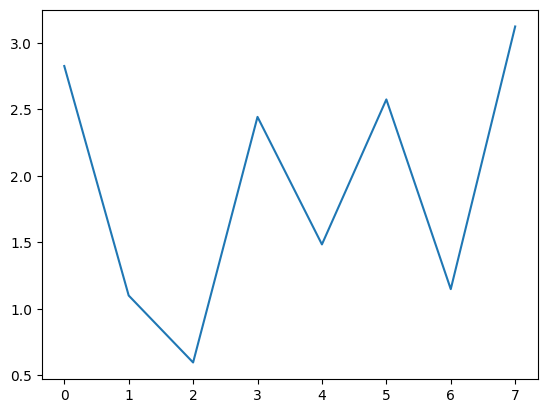

In [ ]:
plt.plot(np.arange(0, len(lineage_df.groupby("Gen")["NRMSE"])), lineage_df.groupby("Gen").mean()["NRMSE"])
#plt.plot(np.arange(0, len(lineage_df["hs"])), lineage_df["hs"])

# Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
temp1 = pd.read_pickle("lineage df 19.pkl")
temp2 = pd.read_pickle("lineage df to 30.pkl")
temp3 = pd.read_pickle("lineage_df 7 to 14.pkl")
temp4 = pd.read_pickle("lineage_df_1.pkl")
lin_df = pd.concat([temp1, temp2, temp3, temp4])
lin_df[["bs", "hs", "epochs", "win_len"]] = lin_df[["bs", "hs", "epochs", "win_len"]].astype("int")
lin_df_g = lin_df.groupby("Gen").mean()

In [ ]:
lin_df

,Gen,model_i,Seed,T,win_len,bs,hs,epochs,num_nodes,NRMSE,RMSE,corr
13,7,13,29,500,6,14,4,99,[140 61 238 208],2.706497,0.495964,0.804852
3,7,3,29,500,6,40,4,53,[ 47 64 124 222],2.598190,0.476117,0.823034
17,7,17,29,500,4,35,5,79,[141 146 72 92 136],2.551392,0.467542,0.820310
3,7,3,29,500,6,40,4,53,[ 47 64 124 222],2.672795,0.489789,0.811581
3,7,3,29,500,6,40,4,53,[ 47 64 124 222],2.647005,0.485063,0.810598
...,...,...,...,...,...,...,...,...,...,...,...,...
25,6,25,260,500,2,4,5,104,[174 147 47 172 104],2.843537,0.666404,0.648257
3,6,3,260,500,6,40,4,53,[ 47 64 124 222],2.932444,0.687240,0.650569
17,6,17,260,500,4,35,5,79,[141 146 72 92 136],2.874866,0.673746,0.649336
25,6,25,260,500,2,4,5,104,[174 147 47 172 104],2.870611,0.672749,0.637540


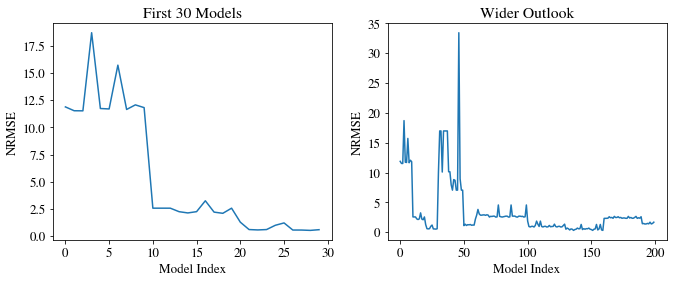

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.size"] = 13

fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].set_title("First 30 Models")
ax[0].plot(np.arange(0, 30), lin_df.sort_values(by="Gen")["NRMSE"].iloc[:30])
ax[0].set_ylabel("NRMSE")
ax[0].set_xlabel("Model Index")

ax[1].set_title("Wider Outlook")
ax[1].plot(np.arange(0, 200), lin_df.sort_values(by="Gen")["NRMSE"].iloc[:200])
ax[1].set_ylabel("NRMSE")
ax[1].set_xlabel("Model Index")
plt.savefig("Genetic Algo Performance", dpi=220)

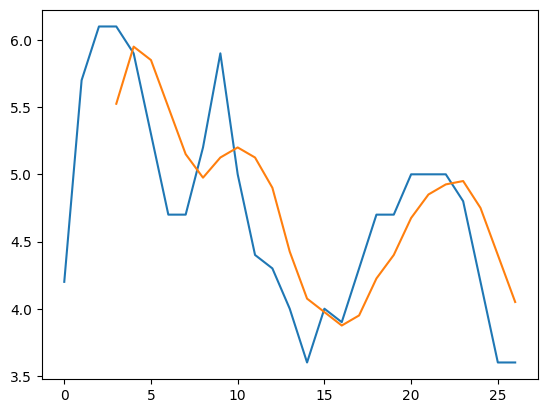

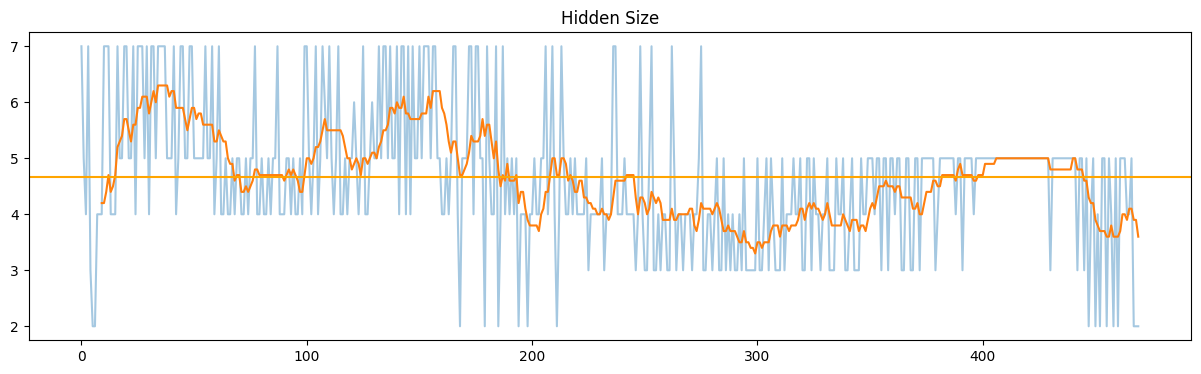

In [ ]:
plt.plot(np.arange(0, len(lin_df_g)), lin_df_g.sort_values(by="Gen")["hs"])
plt.plot(np.arange(0, len(lin_df_g)), lin_df_g["hs"].rolling(window=4).mean())
plt.show()
plt.figure(figsize=(15,4), dpi=100)
plt.title("Hidden Size")
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["hs"], alpha=0.4)
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["hs"].rolling(window=10).mean())
plt.axhline(lin_df["hs"].mean(), color="orange")
plt.show()
## DRAW LIN REG LINE GOING DOWN

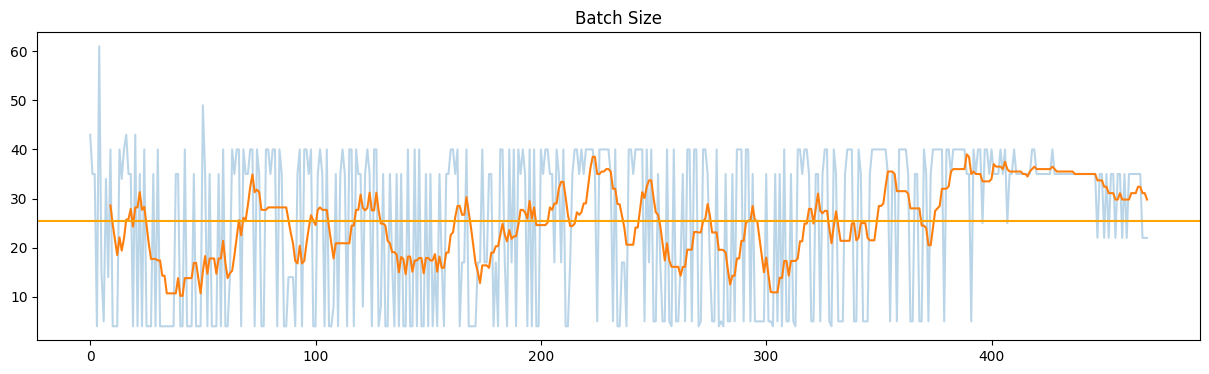

In [ ]:
plt.figure(figsize=(15,4), dpi=100)
plt.title("Batch Size")
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["bs"], alpha=0.3)
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["bs"].rolling(window=10).mean())
plt.axhline(lin_df["bs"].mean(), color="orange")
## INCLUDE HIST SHOWING NORMALITY WITH A TEST??

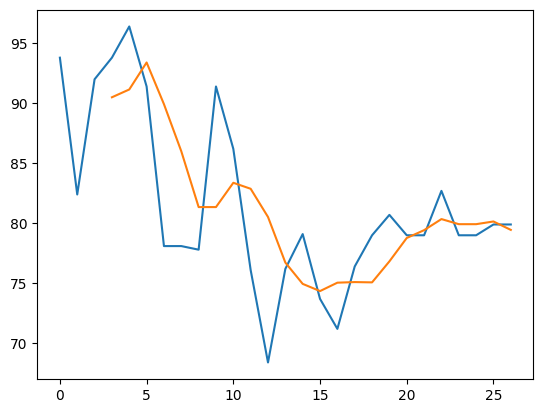

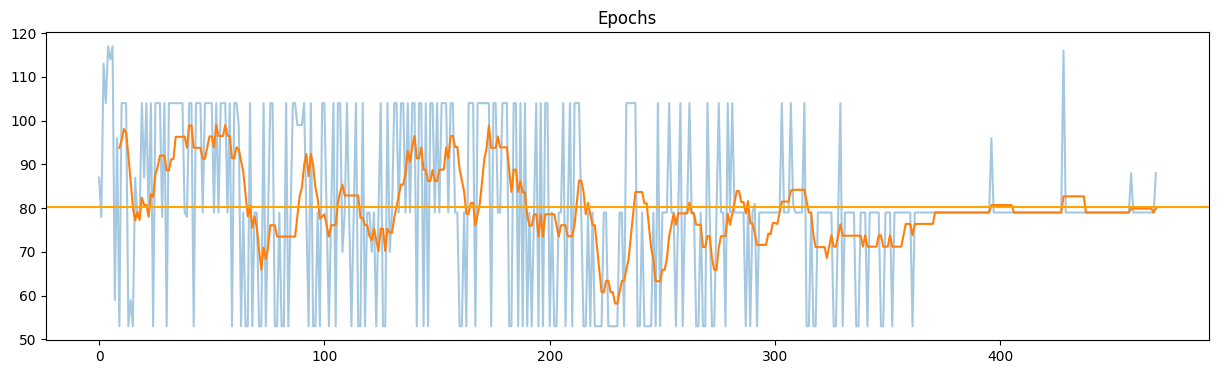

In [ ]:
plt.plot(np.arange(0, len(lin_df_g)), lin_df_g.sort_values(by="Gen")["epochs"])
plt.plot(np.arange(0, len(lin_df_g)), lin_df_g["epochs"].rolling(window=4).mean())
plt.show()
plt.figure(figsize=(15,4), dpi=100)
plt.title("Epochs")
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["epochs"], alpha=0.4)
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["epochs"].rolling(window=10).mean())
plt.axhline(lin_df["epochs"].mean(), color="orange")
plt.show()

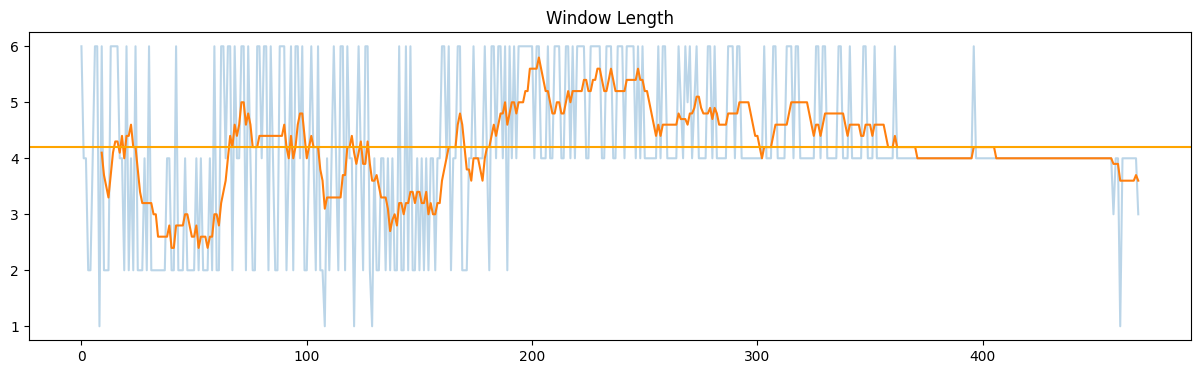

In [ ]:
plt.figure(figsize=(15,4), dpi=100)
plt.title("Window Length")
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["win_len"], alpha=0.3)
plt.plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["win_len"].rolling(window=10).mean())
plt.axhline(lin_df["win_len"].mean(), color="orange")
## INCLUDE HIST SHOWING NORMALITY WITH A TEST??

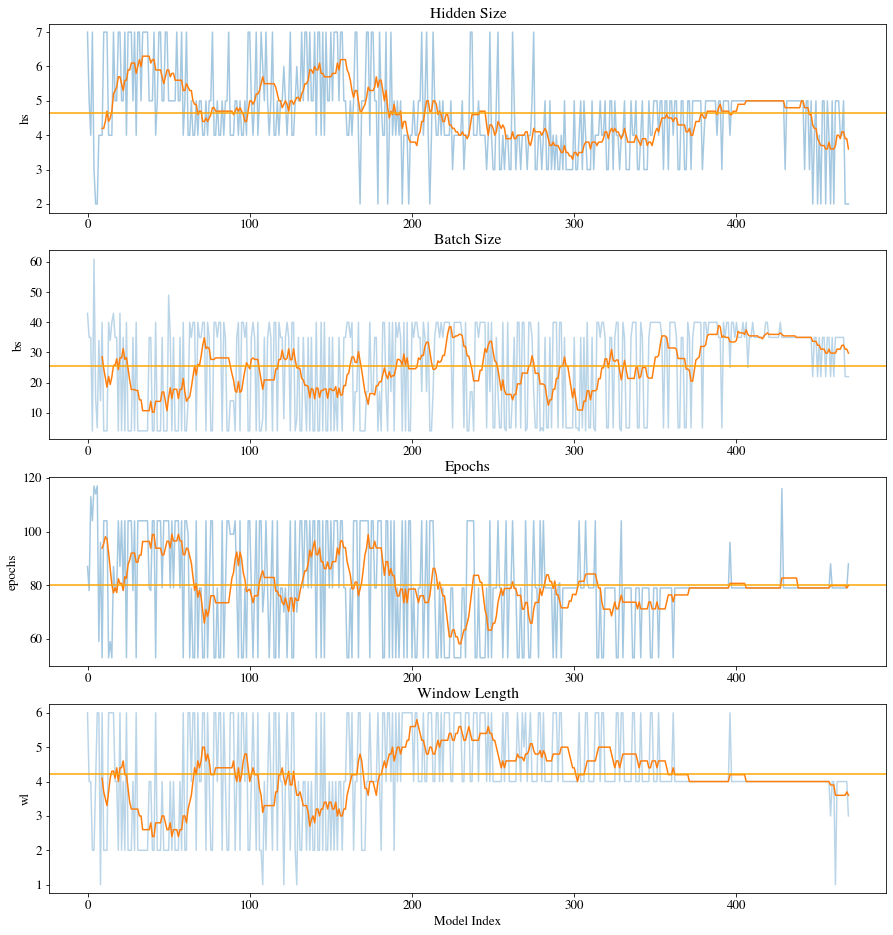

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(15,16))
ax[0].set_title("Hidden Size")
ax[0].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["hs"], alpha=0.4)
ax[0].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["hs"].rolling(window=10).mean())
ax[0].axhline(lin_df["hs"].mean(), color="orange")
ax[0].set_ylabel("hs")

ax[1].set_title("Batch Size")
ax[1].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["bs"], alpha=0.3)
ax[1].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["bs"].rolling(window=10).mean())
ax[1].axhline(lin_df["bs"].mean(), color="orange")
ax[1].set_ylabel("bs")

ax[2].set_title("Epochs")
ax[2].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["epochs"], alpha=0.4)
ax[2].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["epochs"].rolling(window=10).mean())
ax[2].axhline(lin_df["epochs"].mean(), color="orange")
ax[2].set_ylabel("epochs")

ax[3].set_title("Window Length")
ax[3].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["win_len"], alpha=0.3)
ax[3].plot(np.arange(0, len(lin_df)), lin_df.sort_values(by="Gen")["win_len"].rolling(window=10).mean())
ax[3].axhline(lin_df["win_len"].mean(), color="orange")
ax[3].set_xlabel("Model Index")
ax[3].set_ylabel("wl")

fig.savefig("Summary Genetic algo", dpi=300)

In [ ]:
epochs = 80
win_len = 4
bs = 35
hs = 4
num_nodes = [141 146 92 136]

# Application of Techniques

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.models import Sequential
from math import sqrt
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import pearsonr
from threading import Thread
from statsmodels.tsa.ar_model import AutoReg


def NRMSE(Y_true, Y_pred):
    numerator = np.sqrt(np.mean((Y_true - Y_pred)**2))
    denominator = np.abs(np.mean(Y_true))
    return numerator / denominator

def RMSE(Y_true, Y_pred):
    return np.sqrt(np.mean((Y_true - Y_pred)**2))

def MAE(Y_true, Y_pred):
    return np.mean(np.abs(Y_true - Y_pred))

def MAPE(Y_true, Y_pred):
    mask = Y_true != 0
    return (np.mean(np.abs((Y_true[mask] - Y_pred[mask]) / Y_true[mask])) * 100)

def get_key(d, val):
    return [k for k, v in d.items() if v == val]

## Code

In [ ]:
error_df = pd.DataFrame(columns=["Seed", "T", "Model", "NRMSE", "RMSE", "MAE", "MAPE", "CORR"])

for i in range(1):
    ## –––––––––––––––––––––––––––––––– Data –––––––––––––––––––––––––––––––– ##

    if i % 5 == 0:
      error_df.to_pickle(f"Markov Data {i}.pkl")

    T = np.random.choice([250, 500, 750])
    seed = np.random.randint(1, 1001)

    dataset = gen_series(T, seed, y_0=[1,2])

    test_size = 0.10
    win_length = 4
    num_features = 1
    epochs = 80

    Y_test_df = dataset[int(len(dataset)*(1-test_size)):]
    Y_train_df = dataset[-int(len(dataset)*test_size):]

    dataset = np.array(dataset).reshape(len(dataset), 1)
    scaler = StandardScaler()
    scaler.fit(dataset)
    scaled_data = scaler.transform(dataset)

    test_size_2 = (0.1*len(dataset) + win_length)/len(dataset)

    x_train, x_test, y_train, y_test = train_test_split(scaled_data, scaled_data,
                                                        test_size=test_size_2, shuffle=False)

    train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=35)
    test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=35)

    # ## –––––––––––––––––––––––––––––––– LSTM –––––––––––––––––––––––––––––––– ##

    # arch = [141, 146, 92, 136]

    # model_lstm = Sequential()

    # model_lstm.add(LSTM(arch[0], activation="relu", input_shape=(win_length, num_features), return_sequences=True))

    # for i in range(1, len(arch)-1):
    #   model_lstm.add(LSTM(arch[i], activation="relu", return_sequences=True))

    # model_lstm.add(LSTM(arch[-1], activation="relu", return_sequences=False))
    # model_lstm.add(Dense(1))

    # model_lstm.compile(optimizer="adam", loss="mse")

    # model_lstm.fit(train_generator, epochs=epochs,
    #                   shuffle=False)

    # pred_lstm = model_lstm.predict(test_generator, verbose=0)

    # Y_hat_df = pd.DataFrame(scaler.inverse_transform(pred_lstm))
    # Y_hat_df.set_index(Y_test_df.index, inplace=True)

    # Y_test, Y_hat = Y_test_df, Y_hat_df.to_numpy().reshape(len(Y_hat_df), 1)
    # Y_NRMSE = NRMSE(Y_test, Y_hat)
    # Y_RMSE = RMSE(Y_test, Y_hat)
    # Y_MAE = MAE(Y_test, Y_hat)
    # Y_MAPE = MAPE(Y_test, Y_hat)
    # CORR = pearsonr(Y_test, Y_hat)[0]
    # error_df_row = pd.DataFrame({"Seed": seed, "T": T, "Model": "LSTM", "NRMSE": Y_NRMSE, "RMSE": Y_RMSE, "MAE": Y_MAE, "MAPE": Y_MAPE, "CORR": CORR}, index=[i])
    # error_df = pd.concat([error_df, error_df_row])

    ## –––––––––––––––––––––––––––––––– AR(2) –––––––––––––––––––––––––––––––– ##

    # ar = AutoReg(Y_train_df, 2)
    # res = ar.fit()
    # Y_hat_df_rec = res.forecast(len(Y_test_df))

    # Y_test, Y_hat = Y_test_df.reshape(len(Y_test_df),), Y_hat_df_rec.reshape(len(Y_hat_df_rec),)
    # Y_NRMSE = NRMSE(Y_test, Y_hat)
    # Y_RMSE = RMSE(Y_test, Y_hat)
    # Y_MAE = MAE(Y_test, Y_hat)
    # Y_MAPE = MAPE(Y_test, Y_hat)
    # CORR = pearsonr(Y_test, Y_hat)[0]
    # error_df_row = pd.DataFrame({"Seed": seed, "T": T, "Model": "AR(2) R", "NRMSE": Y_NRMSE, "RMSE": Y_RMSE, "MAE": Y_MAE, "MAPE": Y_MAPE, "CORR": CORR}, index=[i])
    # error_df = pd.concat([error_df, error_df_row])

    # p = res.params

    # def y(y_t, p):
    #     y = p[0] + p[1]*y_t[0] + p[2]*y_t[1]
    #     y_t = np.hstack([y, y_t[0]])

    #     return y_t

    # y_0 = np.array([Y_train_df[-1][0], Y_train_df[-2][0]])
    # y_t = y_0
    # y_res = []

    # for i in range(len(Y_test_df)):
    #   y_t = y(y_t, p)
    #   y_res.append(y_t[0])
    #   y_t[0] = Y_test_df[i][0]

    # Y_test, Y_hat = Y_test_df.reshape(len(Y_test_df),), np.array([y_res]).reshape(len(y_res),)
    # Y_NRMSE = NRMSE(Y_test, Y_hat)
    # Y_RMSE = RMSE(Y_test, Y_hat)
    # Y_MAE = MAE(Y_test, Y_hat)
    # Y_MAPE = MAPE(Y_test, Y_hat)
    # CORR = pearsonr(Y_test, Y_hat)[0]
    # error_df_row = pd.DataFrame({"Seed": seed, "T": T, "Model": "AR(2) E", "NRMSE": Y_NRMSE, "RMSE": Y_RMSE, "MAE": Y_MAE, "MAPE": Y_MAPE, "CORR": CORR}, index=[i])
    # error_df = pd.concat([error_df, error_df_row])

    # Create the model and fit it to the data
    model = sm.tsa.MarkovAutoregression(Y_train_df.reshape(len(Y_train_df),), k_regimes=2, order=2, switching_ar=True)
    res = model.fit()

    # Print summary of the model
    print(res.summary())
    #res.forecast(len(Y_test_df))

    # Specify the initial regime
    startprob = np.array([0.5, 0.5])

    # Forecast the states
    n_periods = 5
    predicted_states = res.predict(exog=np.zeros((n_periods, 1)), start=startprob)
    s = 5


                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                   23
Model:             MarkovAutoregression   Log Likelihood                 -24.705
Date:                  Tue, 14 Mar 2023   AIC                             67.409
Time:                          01:15:15   BIC                             77.629
Sample:                               0   HQIC                            69.979
                                   - 23                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0827      0.371     -0.223      0.824      -0.810       0.644
ar.L1          0.5711      0.268    

TypeError: ignored

In [ ]:
import numpy as np
import statsmodels.api as sm

# Define the data
y = np.array([1.1, 0.9, 1.2, 1.1, 1.0, 0.8, 0.7, 0.9, 0.8, 1.1])

# Define the model
mod = sm.tsa.MarkovAutoregression(y, k_regimes=2, order=1)

# Estimate the model parameters
res = mod.fit()

# Specify the initial regime
startprob = np.array([0.5, 0.5])

# Forecast the states
n_periods = 5
predicted_states = res.predict(1)

# Forecast the future values
#predicted_values = mod.forecast(predicted_states, exog=np.zeros((n_periods, 1)))
print(predicted_states)


[0.93400168 1.00450229 0.9810018  0.95750004 0.91049559 0.88699965
 0.93399787 0.91050122]


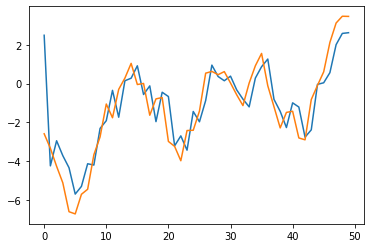

In [ ]:
plt.plot(np.arange(0, len(y_res)), y_res)
plt.plot(np.arange(0, len(Y_test_df)), Y_test_df)